# Regularization and Learning Curves


Spring 2019 - Instructors: Foster Provost and Carlos Fernandez

Teaching Assistant: Carlos Fernandez

***

Import all of the packages we will need.

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

# Our custom libraries!
import sys
sys.path.append("..")
from ds_utils.decision_surface import *

### Complexity control, revisited

Recall that one of the most important fundamental principles underlying data science, the basis for machine learning, is *complexity control*.  We must manage the tension between allowing ourselves to fit complex patterns in the data (a good thing), and the tendency to fit idiosyncracies in a particular data set--things that do not generalize (a bad thing).  So, we attempt to control complexity.  One way to control complexity is just not to allow our data mining procedure to fit complex models in the first place.  That's what we do when we build linear models from small sets of features.  But let's consider the case where we think larger feature sets or non-linearities might add important predictive power--so we will attempt to control complexity in a data-driven fashion.

We will be using the concrete data from one of your previous homeworks.

In [2]:
concrete_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
concrete_df = pd.read_excel(concrete_url).dropna()
concrete_df.rename(columns={
    "Cement (component 1)(kg in a m^3 mixture)"             : "cement",
    "Blast Furnace Slag (component 2)(kg in a m^3 mixture)" : "slag",
    "Fly Ash (component 3)(kg in a m^3 mixture)"            : "fly_ash",
    "Water  (component 4)(kg in a m^3 mixture)"             : "water",
    "Superplasticizer (component 5)(kg in a m^3 mixture)"   : "superplasticizer",
    "Coarse Aggregate  (component 6)(kg in a m^3 mixture)"  : "coarse_agg",
    "Fine Aggregate (component 7)(kg in a m^3 mixture)"     : "fine_agg",
    "Age (day)"                                             : "age",
    "Concrete compressive strength(MPa, megapascals) "      : "strength"
}, inplace= True)

concrete_df.head(5)

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Suppose we want to predict which concrete formulas are strong enough for a particular application we have in mind (say 35 MPA or more). This would be a binary classification problem.

In [3]:
concrete_df["is_strong"] = concrete_df.strength >= 35
concrete_df = concrete_df.drop("strength", axis="columns")
X = concrete_df.iloc[:, :-1]
Y = concrete_df.is_strong

### Complexity control for logistic regression (regularization)

Recall that when fitting a logistic regression classifier, we try to find the set of weights, $\textbf{w}$, that maximize the fit to the data, based on some fit (objective) function. In this case, let's call our objective function $g()$, which means that we want $\arg\max_\textbf{w} g(\textbf{x}, \textbf{w})$.

Since we are trying to find the set of weight without too much complexity, when we perform **regularization** we **penalize** our fit as it gets more complex.  This is achieved by adding a "penalty term" into the objective function, and using a "regularization parameter" $\lambda$ (also sometimes represented as `c`, which is usually $\frac{1}{\lambda}$ so smaller values of `c` lead to larger complexity penalties) to specify how much importance our optimization procedure should place on the fit vs. the penalty:

$\arg\max_\textbf{w} g(\textbf{x}, \textbf{w}) - \lambda \cdot \text{penalty}(\textbf{w})$.

The two most common type of regularization in logistic regression are the so-called $L_1$ and $L_2$ regularizations, which simply use the sum of the absolute value of the weights (w) and the sum of the squares of the weights, respectively, as the penalty.


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def get_polynomial(degree, model):
    # create different powers of X
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("model", model)])
    return pipeline

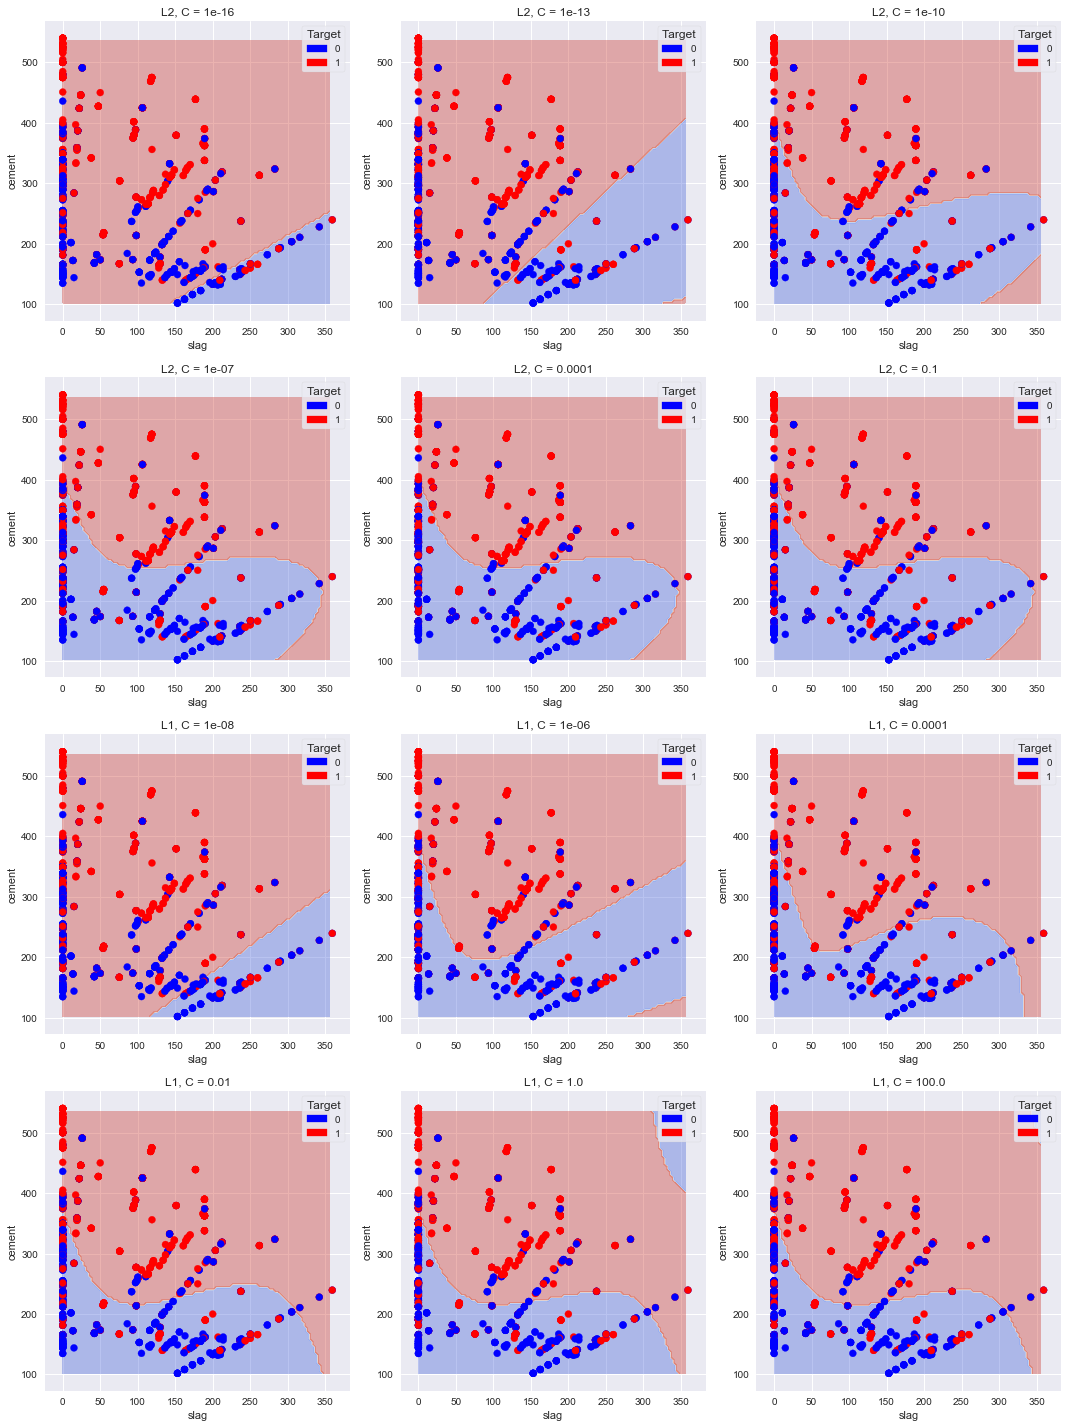

In [5]:
# Let's use 3rd degree polynomial
degree = 3
cs = {"L2": range(-16,1, 3), "L1": range(-8, 4, 2)} 
# Plot different regularization values for L1 and L2 regularization
position = 0
plt.figure(figsize=(15, 20))
for regularization in ['L2', 'L1']:    
    # Try some regularization values
    for i in cs[regularization]:
        # Modeling
        c = np.power(10.0, i)
        model = LogisticRegression(penalty=regularization.lower(), C=c)
        model = get_polynomial(degree, model)
        # Plotting
        position += 1
        plt.subplot(4, 3, position)
        Decision_Surface(X, "slag", "cement", Y, model)
        plt.title(regularization + ", C = " + str(np.power(10.0, i)))
plt.tight_layout()
plt.show()

### Feature's weights with L1/L2  and normalization

Let's take a look to the different values of our weights with each type of penalty but first, let's understand **normalization**. 

What is normalization? Why do we need normalization? Each time we work with data, it is very important to consider the "scale" of the features. Some features might have distinct values from 1 to 1000, and other features might have values from 0 to 1. As many different data science/machine learning methods compare data along different dimensions, it can often be important to make sure the dimensions are comparable.

To do this re-scaling there are are many approaches, the most common being:

- _Normalization_ : we rescale our data so that the features have unit norms  
- _Standardization_ : we rescale our data acting as if each features is normally distributed (Gaussian with zero mean and unit variance)
- _Scaling to a range_ : we rescale our data based on the minimum and maximum value of each feature 


( sklearn has a built-in function to help us re-scaling our data -- see below)

**Let's take a look at the data before and after re-scaling.**

Before re-scaling:

In [6]:
X.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [7]:
from sklearn.preprocessing import scale
X_scaled = pd.DataFrame(scale(X, axis=0, with_mean=True, with_std=True, copy=True), columns=X.columns.values)

After re-scaling:

In [8]:
X_scaled.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
0,2.477918,-0.856886,-0.847132,-0.916663,-0.620225,0.863160,-1.217658,-0.279733
1,2.477918,-0.856886,-0.847132,-0.916663,-0.620225,1.056170,-1.217658,-0.279733
2,0.491443,0.795533,-0.847132,2.175367,-1.038944,-0.526514,-2.240913,3.553066
3,0.491443,0.795533,-0.847132,2.175367,-1.038944,-0.526514,-2.240913,5.057677
4,-0.790432,0.678414,-0.847132,0.488805,-1.038944,0.070531,0.647908,4.978487


In [9]:
summary = X_scaled.describe()
for column in summary:
    summary[column] = summary[column].apply(lambda x: round(x,1))
summary

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
count,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0
mean,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.7,-0.9,-0.8,-2.8,-1.0,-2.2,-2.2,-0.7
25%,-0.9,-0.9,-0.8,-0.8,-1.0,-0.5,-0.5,-0.6
50%,-0.1,-0.6,-0.8,0.2,0.0,-0.1,0.1,-0.3
75%,0.7,0.8,1.0,0.5,0.7,0.7,0.6,0.2
max,2.5,3.3,2.3,3.1,4.4,2.2,2.7,5.1


### Visualizing the weights as we change the regularization

Before we try and delve into the impact regularization has on the coefficients logistic regression assigns to different features, let's investigate the coefficients before any regularization is performed.

In [10]:
def get_coeffs(X, Y, model):
    model.fit(X, Y)
    return dict(zip(X.columns, model.coef_[0]))

pd.DataFrame([get_coeffs(X_scaled, Y, LogisticRegression())])

,age,cement,coarse_agg,fine_agg,fly_ash,slag,superplasticizer,water
0,2.482713,1.560854,0.016547,-0.428479,0.443604,0.829292,0.603477,-0.64746


Now we can see how the model weights change with differing degrees of complexity control.

In [11]:
def get_lr_regularization_paths(X, Y, regtype, reg_values):
    coefs = [get_coeffs(X, Y, LogisticRegression(penalty=regtype, C=10**reg)) for reg in reg_values]
    df = pd.DataFrame(coefs)
    df["regularization"] = reg_values
    df.set_index("regularization", inplace=True)    
    return df

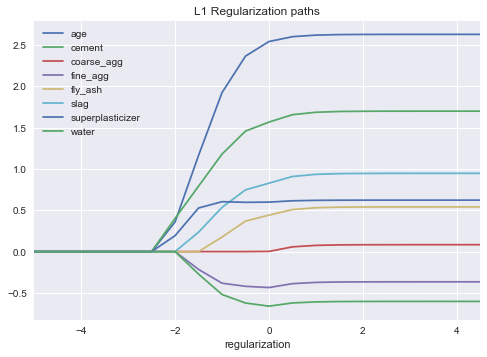

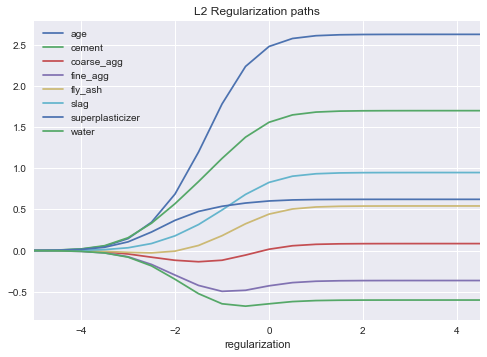

In [12]:
# Go through a bunch of ascending regularization parameters
regs = np.arange(-5, 5, 0.5)  
# Get coefficients 
l1_coefs = get_lr_regularization_paths(X_scaled, Y, "l1", regs)
l1_coefs.plot()
plt.title("L1 Regularization paths")
l2_coefs = get_lr_regularization_paths(X_scaled, Y, "l2", regs)
l2_coefs.plot()
plt.title("L2 Regularization paths")
plt.show()

### Hyper-parameter tuning

As seen previously, most models have a number of settings that impact their behavior and therefore generalization performance (such as the regularization settings we have seen today). One common use of cross-validation is to tune these "hyper-parameters" (so-called because the coefficients in a model are usually called parameters). One can select several values for a particular hyper-parameter, use cross-validation to estimate model generalization performance, and keep the model that offered the best results.

For example, we could try different regularization settings and keep the one that produces the model with the highest accuracy. 

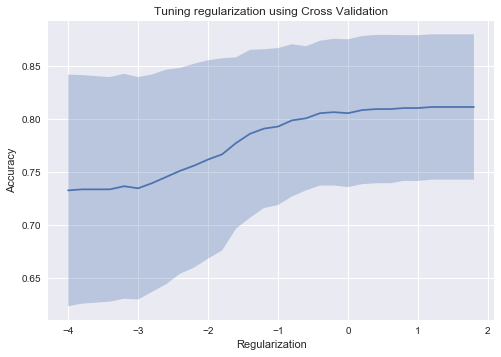

In [13]:
from sklearn.model_selection import cross_val_score

folds = 10

def score_model(X, Y, model, scoring="accuracy"):
    scores = cross_val_score(model, X, Y, scoring=scoring, cv=folds)
    return {"mean": scores.mean(), "std_dev": scores.std()}

reg_vals = np.arange(-4, 2, 0.2)
scores_list = [score_model(X_scaled, Y, LogisticRegression(C=10**reg)) for reg in reg_vals]

accys = np.array([score["mean"] for score in scores_list])
# Confidence interval for the mean
accys_std = 1.96 * np.array([score["std_dev"] for score in scores_list]) / np.sqrt(folds)

plt.plot(reg_vals, accys)
plt.fill_between(reg_vals, accys + accys_std, accys - accys_std, alpha=0.3)
plt.xlabel("Regularization")
plt.ylabel("Accuracy")
plt.title("Tuning regularization using Cross Validation")
plt.show()

### Grid Search: tuning many hyper-parameters

The concept explored above can be extended in a very natural way to simultaniuosly optimize many hyper-parameters using a technique called "grid search". One first defines a "grid", of hyper-parameter values to explore. The grid search explores all possible combinations of these settings, selecting the setting with the best cross-validated value of the chosen generalization measure.

Sklearn provides a convenient implementation.

In [14]:
from sklearn.model_selection import GridSearchCV

grid = {"polynomial_features__degree": [1, 2, 3], "model__C": [10.0**c for c in np.arange(-2, 7)]}

def Polynomial_Model(degree=1, reg=1):
    return get_polynomial(degree=degree, model=LogisticRegression(C=reg))

# gridsearchcv behaves just like a model, with fit, predict, and some additional functionalities
tuned_model = GridSearchCV(Polynomial_Model(), grid, scoring="accuracy", cv=10, verbose=1)
tuned_model.fit(X_scaled, Y)

print ("Best accuracy: %0.3f, using: " % tuned_model.best_score_)
print (tuned_model.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best accuracy: 0.829, using: 
{'model__C': 1000.0, 'polynomial_features__degree': 2}


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   52.3s finished


Let's take a look at the performance over our parameter grid.

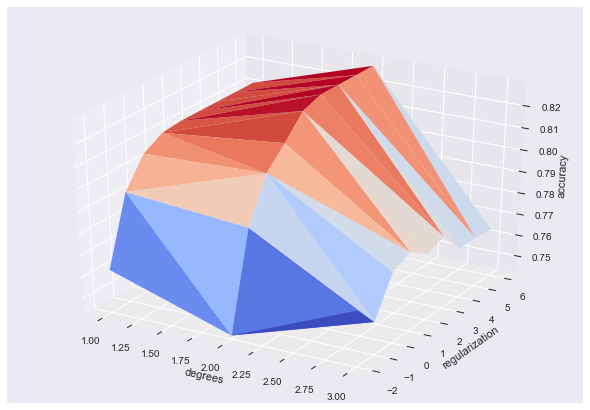

In [15]:
from mpl_toolkits.mplot3d import Axes3D

means = tuned_model.cv_results_['mean_test_score']
stds = tuned_model.cv_results_['std_test_score']
params = tuned_model.cv_results_['params']

degrees = [param["polynomial_features__degree"] for param in params]
reg_vals = [np.log10(param["model__C"]) for param in params]

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(degrees, reg_vals, means, linewidth=0.1, cmap=plt.cm.coolwarm)
ax.set_xlabel('degrees')
ax.set_ylabel('regularization')
ax.set_zlabel('accuracy')
plt.show()

**A word of caution: ** Grids with many potential values combined with slow-ish model training can really blow up the time it takes to tune a model! 

Also, note that both of the hyper-parameters tuned above are used to control complexity. This will nearly always be the case when optimizing a ML model-- getting the best generalization performance out of one's model means balancing the tension between allowing a model to fit fine-grained patterns to the data (a good thing), and the tendancy to fit idiosyncracies in a particular data set-- things that don't generalize (a bad thing). 

### Learning curves for model assessment

Throughout the past lectures we analyzed and compared model accuracies using a unique **sample size** that was essentially fixed and determined by the size of the datasets we were considering. 

Very often we also want to assess the relationship between how much data we are using to train the models, and the generalization performance we achieve.  For example, do we have a good idea whether we should invest in acquiring more training data? The only way to answer this question is again, experiment with different sample sizes. The main way to do this assessment is via **_learning curves_**: analyze the change of the generalization performance (accuray on the holdout data, in this case) based on different sizes of the training set.

What would we expect to see? Holding everything else fixed, the generalization should be better with more training data, up until a certain point. Then, more data won't increase generalization performance.

In [16]:
import sklearn.model_selection as cv
from sklearn.metrics import accuracy_score

def evaluate_model_on_sample(X, Y, model, pct, scoring=accuracy_score):
    kf = cv.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []    
    for train_index, test_index in kf.split(X, Y):  
        # only take a portion of the training
        train_size = len(train_index)
        sampled_indices = np.random.permutation(train_index)[:int(pct*train_size)]
        model.fit(X.iloc[sampled_indices], Y[sampled_indices])
        scores.append(scoring(Y[test_index], model.predict(X.loc[test_index])))       
    return np.mean(scores)

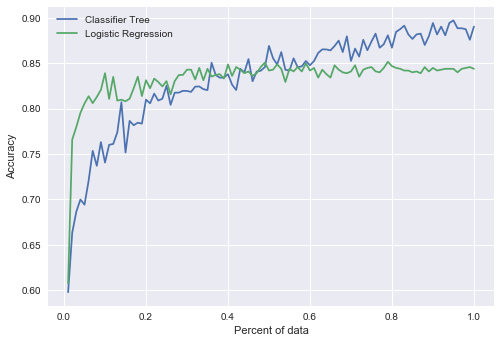

In [17]:
from sklearn.tree import DecisionTreeClassifier

pcts = np.linspace(0.01,1,100).tolist()
# Get scores for each classifier
dt_scores = [evaluate_model_on_sample(X, Y, DecisionTreeClassifier(), pct) for pct in pcts]
lr_scores = [evaluate_model_on_sample(X, Y, LogisticRegression(), pct) for pct in pcts]
# Plot without confidence interval
plt.plot(pcts, dt_scores, label="Classifier Tree")
plt.plot(pcts, lr_scores, label="Logistic Regression")
plt.xlabel("Percent of data")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As we can see, learning curves will help to determine at least 2 things:

- We can see which model performs better or worse for each sample size (e.g. Decision Tree vs Logistic Regression)
- We can get a sense of whether getting more data (or using less) will improve (or not degrade) generalization.

Very often, the more data we have, the more "complex" models we can use (as shown in the chart above).